# Geolgic Mapping in the era of Machine Learning and Drones

This notebook uses an approach by: Swain, M.J. & Ballard, D.H. Int J Comput Vision (1991) 7: 11. doi:10.1007/BF00130487

The algorithm is based on OpenCV and Tensorflow

## Introduction

Humans have evolved to use geometric cues to classify objects

In [2]:
import numpy as np
# import matplotlib.pyplot as plt
from matplotlib.pyplot import *
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle
from time import time
from skimage import color
from skimage import io

from scipy import ndimage
from scipy import misc
import gc

## Load useful functions

In [3]:
# %load ../../data_preprocessing/functions.py
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

# A function to plot a matrix
def plot_image(data, colorspace='binary'):
    fig = plt.figure(figsize=(10,10)) 
    ax = fig.add_subplot(111)
    ax.imshow(data, cmap=colorspace)
    
    
def normalize_array(array):
    array_min = array.min(axis=(0, 1), keepdims=True)
    array_max = array.max(axis=(0, 1), keepdims=True)
    normalized_array = (array - array_min)/(array_max - array_min)
    
    return normalized_array

def normalize_with_preset(array, max_value, min_value):
    normalized_array = (array - min_value)/(max_value - min_value)
    
    return normalized_array


def recreate_image(labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    image = np.zeros((w, h))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = labels[label_idx]
            label_idx += 1
    return image

def overlay_images(image1, image2, colorspace1='binary', colorspace2='magma', transparency=0.5):
    plt.imshow(image1, cmap=colorspace1, interpolation='nearest')
    plt.imshow(image2, cmap=colorspace2, alpha=transparency, interpolation='bilinear')
    plt.show()
    
def flatten_normalize_neighbors(training_set, global_max=233, global_min=69):
    flattened_neighbors = []
    neighbors = training_set['neighbors']

    for i in range(len(neighbors)):
        numpy_array = np.array(neighbors[i]).reshape(-1, 1)
        normalized_neighbors = normalize_with_preset(numpy_array, global_max, global_min)
        flattened_neighbors.append(normalized_neighbors)
    
    return np.array(flattened_neighbors).reshape((len(flattened_neighbors), -1))

def extract_values_from_training_data_locations(training_data, image_channel):
    data_values = []
    
    for row in training_data:
        data_values.append(np.array([(image_channel[row[0], row[1]]), row[2]]))
        
    data_values = np.array(data_values)
    
    return data_values

def extract_neighborhood_values_from_training_data_locations(training_data, image_channel):
    data_values = []
    
    for row in training_data:
        data_values.append(np.array([(image_channel[row[0], row[1]]), row[2]]))
        
    data_values = np.array(data_values)
    
    return data_values

def flatten_neighbors(neighbors):
    data_values = []
    
    for neighbor in neighbors:
        #data_values.append(neighbor[0].reshape(-1, 1))
        data_values.append(neighbor[0].reshape(-1, 1))
    
    data_values = np.array(data_values)
    
    return data_values

def extract_labels_from_set(dataset):
    labels = []
    for neighbor in training_set:
        labels.append(neighbor[1])

    return np.array(labels).flatten()

## Read data

In [4]:
rgb = np.load('../../data_preprocessing/data_preprocessing/numpy_data/indios_b/normalized_filtered_rgb.npy')
hsv = np.load('../../data_preprocessing/data_preprocessing/numpy_data/indios_b/normalized_filtered_hsv.npy')
rgb.shape

(10000, 6000, 3)

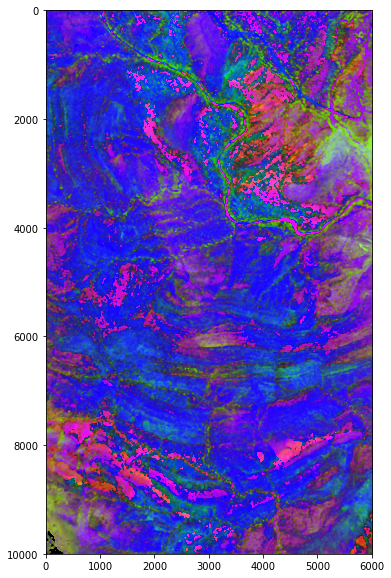

In [20]:
plot_image(hsv)

In [5]:
w, h, c = tuple(rgb.shape)

## Flatten the image, to pass through K-Means algorithm

In [6]:
flattened_r = rgb[:, :, 0].flatten().reshape(-1, 1)
flattened_g = rgb[:, :, 1].flatten().reshape(-1, 1)
flattened_b = rgb[:, :, 2].flatten().reshape(-1, 1)

unflattened_r = rgb[:, :, 0]
unflattened_g = rgb[:, :, 1]
unflattened_b = rgb[:, :, 2]

flattened_h = hsv[:, :, 0].flatten().reshape(-1, 1)
flattened_s = hsv[:, :, 1].flatten().reshape(-1, 1)
flattened_v = hsv[:, :, 2].flatten().reshape(-1, 1)

unflattened_h = hsv[:, :, 0]
unflattened_s = hsv[:, :, 1]
unflattened_v = hsv[:, :, 2]

## Execute K-Means classification

In [7]:
n_facies = 2

## Randomize dataset

In [8]:
t0 = time()
# Shuffle the array of samples
shuffled_r = shuffle(flattened_r, random_state=0)
# shuffled_g = shuffle(flattened_g, random_state=0)
# shuffled_b = shuffle(flattened_b, random_state=0)

shuffled_h = shuffle(flattened_h, random_state=0)
shuffled_s = shuffle(flattened_s, random_state=0)
# shuffled_v = shuffle(flattened_v, random_state=0)
print("done in %0.3fs." % (time() - t0))

done in 14.786s.


In [9]:
image_r = recreate_image(shuffled_r, w, h)
# image_g = recreate_image(shuffled_g, w, h)
# image_b = recreate_image(shuffled_b, w, h)

In [10]:
# shuffled_rgb = np.dstack([image_r, image_g, image_b])

## Prepare training dataset

In [11]:
r_s_unshuffled = np.hstack([flattened_r, flattened_s])

In [12]:
r_s_shuffled_dataset = np.hstack([shuffled_r, shuffled_s])

## K-Means Clustering

In [13]:
number_of_samples = int(shuffled_r.shape[0]*0.25)

In [14]:
t0 = time()
# Fit the K-Means with the subset of the image
kmeans = KMeans(n_facies, random_state=0).fit(r_s_shuffled_dataset[:(number_of_samples)])
# kmeans_g = KMeans(n_facies, random_state=0).fit(shuffled_r[:(number_of_samples)])
# kmeans_b = KMeans(n_facies, random_state=0).fit(shuffled_r[:(number_of_samples)])

# kmeans_h = KMeans(n_facies, random_state=0).fit(shuffled_h[:(number_of_samples)])
print("done in %0.3fs." % (time() - t0))

done in 110.738s.


In [15]:
t0 = time()
labels = kmeans.predict(r_s_unshuffled)
# labels_g = kmeans_g.predict(flattened_g)
# labels_b = kmeans_b.predict(flattened_b)

# labels_h = kmeans_h.predict(flattened_h)
print("done in %0.3fs." % (time() - t0))
print(labels.shape)

done in 9.842s.
(60000000,)


## Recreate the image

In [16]:
t0 = time()
clusters = recreate_image(labels, w, h)
# clusters_r = recreate_image(labels_r, w, h)
# clusters_g = recreate_image(labels_g, w, h)
# clusters_b = recreate_image(labels_b, w, h)
print("done in %0.3fs." % (time() - t0))

done in 21.989s.


## Display the results

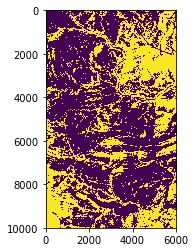

In [17]:
plt.imshow(clusters)
plt.show()

## Filter the results

In [21]:
cluster_subset = clusters[0:6000, 0:6000]

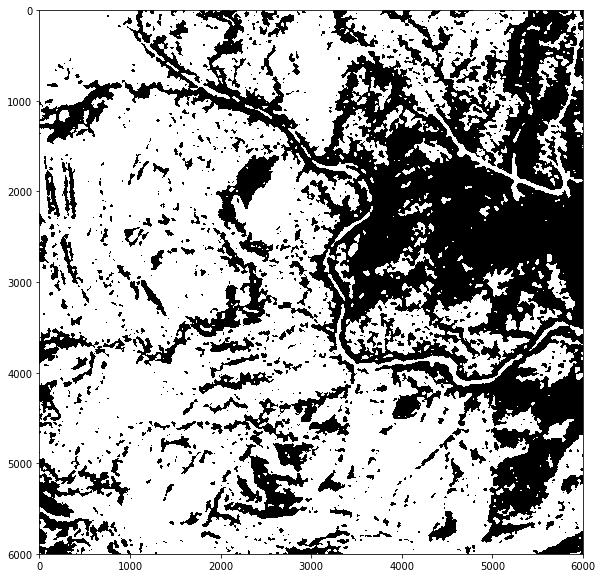

In [22]:
plot_image(cluster_subset)

## Store the subset to use as labels

In [ ]:
np.save('../../../data_preprocessing/data_preprocessing/numpy_data/indios_b/cluster_subset.npy', cluster_subset)

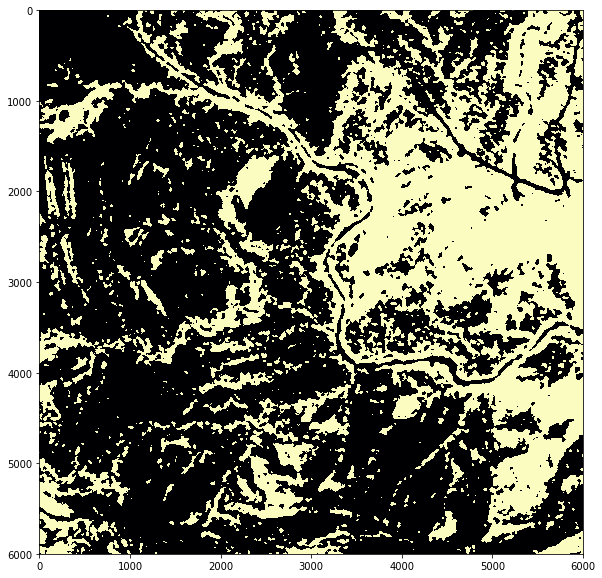

In [23]:
plot_image(cluster_subset, colorspace='magma')

## Save the result into image

In [ ]:
import scipy.misc

In [ ]:
scipy.misc.imsave('../../data_preprocessing/data_preprocessing/numpy_data/indios_b/cluster_rgb_no_pca.jpg', cluster_rgb)

In [ ]:
scipy.misc.imsave('../../data_preprocessing/data_preprocessing/numpy_data/indios_b/clutser_r_no_pca.jpg', clusters_r)
scipy.misc.imsave('../../data_preprocessing/data_preprocessing/numpy_data/indios_b/clutser_g_no_pca.jpg', clusters_g)
scipy.misc.imsave('../../data_preprocessing/data_preprocessing/numpy_data/indios_b/clutser_b_no_pca.jpg', clusters_b)